# LAB 1A

### Imports

In [289]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)
import time
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Define Data

We have three datasets
- Linearly seperapble data from multivariate normal distrubution
- Non linearly seperable data from multivariate normal distrubution
- A different non-seperable dataset

In [407]:
#number of samples
n = 100

def normal_lin_sep_data(n=100):
    mA = np.array([1.0, 0.5])
    sigmaA = 0.5
    mB = np.array([-1.0, -3.0])
    sigmaB = 0.5

    classA = rng.standard_normal(size=(2, n)) * sigmaA + mA[:, None]
    classB = rng.standard_normal(size=(2, n)) * sigmaB + mB[:, None]

    return classA, classB

def normal_non_lin_sep_data(n=100):
    mA = np.array([1.0, 0.5])
    sigmaA = 1.0
    mB = np.array([-1.0, 0])
    sigmaB = 1.0

    classA = rng.standard_normal(size=(2, n)) * sigmaA + mA[:, None]
    classB = rng.standard_normal(size=(2, n)) * sigmaB + mB[:, None]

    return classA, classB

def non_lin_sep_data(n=100):
  mA = np.array([1.0, 0.3])
  sigmaA = 0.2
  mB = np.array([0.0, -0.1])
  sigmaB = 0.3
  classA = np.column_stack([rng.standard_normal(size=(1, round(n*0.5))) * sigmaA - mA[:, None],
                           rng.standard_normal(size=(1, round(n*0.5))) * sigmaA + mA[:, None]])
  classB = rng.standard_normal(size=(2, n)) * sigmaB + mB[:, None]

  return classA, classB

def non_lin_sep_data_2(n=100):
  ndata = n
  mA = np.array([1.0, 0.3])
  sigmaA = 0.2
  mB = np.array([0.0, -0.1])
  sigmaB = 0.3
  
  classA_x = np.concatenate([
      np.random.randn(round(0.5 * ndata)) * sigmaA - mA[0],
      np.random.randn(round(0.5 * ndata)) * sigmaA + mA[0]
  ])
  classA_y = np.random.randn(ndata) * sigmaA + mA[1]
  classA = np.vstack((classA_x, classA_y))

  classB_x = np.random.randn(ndata) * sigmaB + mB[0]
  classB_y = np.random.randn(ndata) * sigmaB + mB[1]
  classB = np.vstack((classB_x, classB_y))
  
  return classA, classB

norm_sep = normal_lin_sep_data(n)
norm_non_sep = normal_non_lin_sep_data(n)
non_sep = non_lin_sep_data_2(n)

## Shuffle and add label

In [408]:
random_order = list(range(2*n))
random.shuffle(random_order)
T = np.column_stack((np.ones((1, n)), (np.zeros((1, n))-1)))[0]
T = T[random_order]
bias = np.ones((1,2*n))

# concatenate class A and B and add bias
norm_sep_combined = np.concatenate(norm_sep, axis=1)
norm_sep_unshuffled = np.vstack([norm_sep_combined, bias])
norm_sep_data = norm_sep_unshuffled[:, random_order]

norm_non_sep_combined = np.concatenate(norm_non_sep, axis=1)
norm_non_sep_unshuffled = np.vstack([norm_non_sep_combined, bias])
norm_non_sep_data = norm_non_sep_unshuffled[:, random_order]

non_sep_combined = np.concatenate(non_sep, axis=1)
non_sep_unshuffled = np.vstack([non_sep_combined, bias])
non_sep_data = non_sep_unshuffled[:, random_order]


## Visualize data

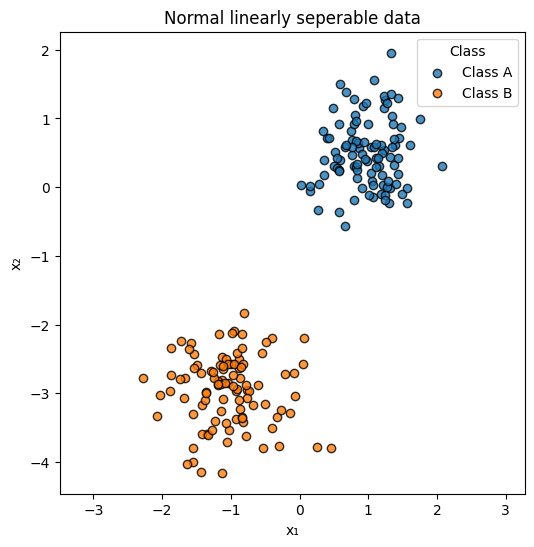

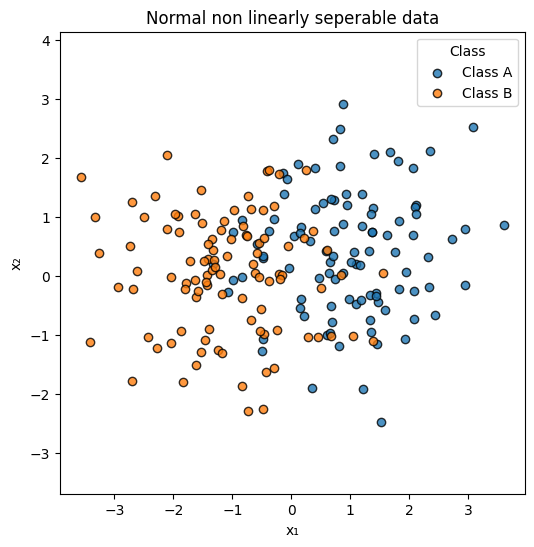

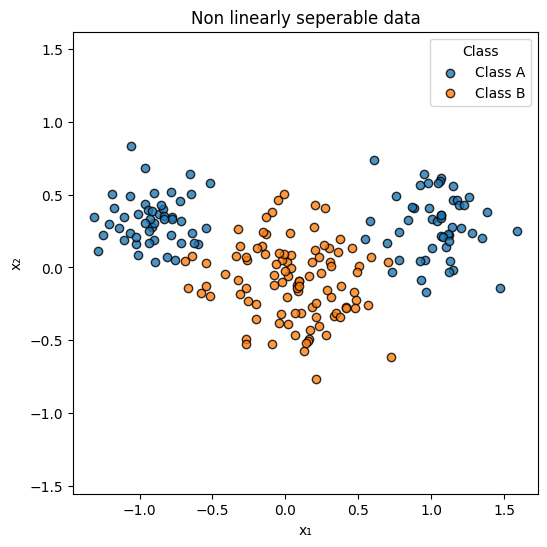

In [409]:
classes = np.array(["Class A" for i in range(n)] + ["Class B" for i in range(n)])
classes = classes[random_order]
    
def plot_labeled_data(X, labels, title="Scatter plot", W = None):
    x = X[0, :]
    y = X[1, :]


    plt.figure(figsize=(6, 6))
    for label in np.unique(labels):
        mask = labels == label
        plt.scatter(x[mask], y[mask], label=str(label), alpha=0.8, edgecolor="k")

    
    if W is not None:
        w1, w2, b = W[0]
        xW = np.linspace(min(x)-0.3, max(x)+0.3, 200)

        if abs(w2) < 1e-8:
            plt.axvline(-b/w1, color="k", linestyle="--", label="Decision boundary")
        else:
            yW = -(w1/w2) * xW - b/w2
            plt.plot(xW, yW, "k--", label="Decision boundary")
            
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.axis("equal")
    plt.legend(title="Class")
    
    
    plt.show()

plot_labeled_data(norm_sep_data, classes, "Normal linearly seperable data")
plot_labeled_data(norm_non_sep_data,classes,"Normal non linearly seperable data")
plot_labeled_data(non_sep_data, classes,"Non linearly seperable data")



## Sequential learning

In [410]:
# helper function to count number of mislabeled samples
def count_mislabeled(X,T,W, style):
    mislabeled = 0
    for i in range(X.shape[1]):
        x = X[:, i]
        y = 0 if W @ x <= 0 else 1
        if style == "delta" and y == 0:
            y = -1
        if y != T[i]:
            mislabeled += 1
    return mislabeled


        

In [411]:
def train_sequential(eta, X,T, style, n_e, w_scale, show = False):
    """
    trains sequentially
    """
    # initalize weights
    W = np.random.randn(1, 3) * w_scale
    epochs = 0
    errors = [0 for _ in range(n_e+1)]
    if style == "perceptron":
        # edit labels to get 0 and 1
        T[T==-1] = 0
        while True:
            # count mislabeled -- should i permute ??
            mislabeled = count_mislabeled(X,T,W, style)
            if epochs > n_e or mislabeled == 0:
                break
            errors[epochs] = mislabeled / X.shape[1]
            for i in range(X.shape[1]):
                x = X[:, i]
                y = 0 if W@x <= 0 else 1
                if y != T[i]:
                    delta_W = eta*x if y==0 else -eta*x
                    W += delta_W
            epochs += 1
    if style == "delta":
        T[T==0] = -1
        while True:
            mislabeled = count_mislabeled(X,T,W,style)
            if epochs > n_e:
                break
            errors[epochs] = mislabeled / X.shape[1]
            for i in range(X.shape[1]):
                t = T[i]
                x = X[:, i]
                e = t - W @ x
                delta_W = eta*e*x
                W += delta_W
            epochs +=1            
    if show:
        plot_labeled_data(X,T,f"{style} learning",W)
    
    return errors, W
        

### Training batch

In [412]:
def train_batch(eta, X,T, style, n_e, w_scale, show = False):
    """
    trains sequentially
    """
    # initalize weights
    W = np.random.randn(1, 3) * w_scale
    epochs = 0
    errors = [0 for _ in range(n_e+1)]
    if style == "delta":
        T[T==0] = -1
        while True:
            mislabeled = count_mislabeled(X,T,W,style)
            if epochs > n_e:
                break
            errors[epochs] = mislabeled / X.shape[1]
            #for i in range(X.shape[1]):
            #    t = T[i]
            #    x = X[:, i]
            #    e = t - W @ x
            #    delta_W = eta*e*x
            #    W += delta_W
            
            W -= eta * (W@X-T)@ X.T
            
            epochs +=1            
    if show:
        plot_labeled_data(X,T,f"{style} learning",W)
    
    return errors, W

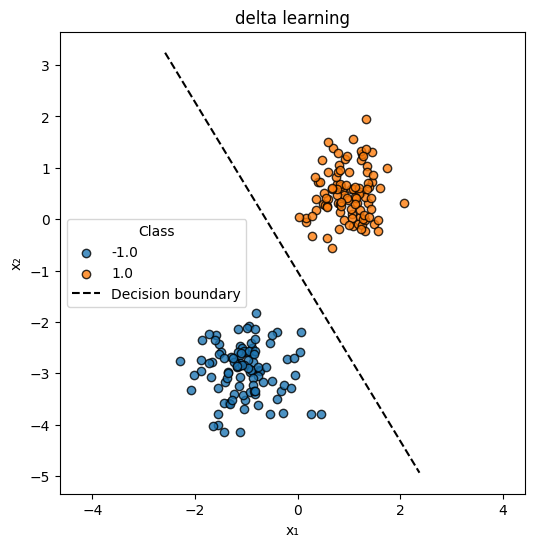

[0.575, 0.465, 0.18, 0.055, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [413]:
errors, W = train_batch(0.0001, norm_sep_data, T, "delta", 100, 0.1, True)
print(errors)

### Tasks

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/816218688.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsD1, label = "$\eta=0.001$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/816218688.py:11: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsD2, label = "$\eta=0.05$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/816218688.py:12: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsD3, label = "$\eta=0.01$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/8162186

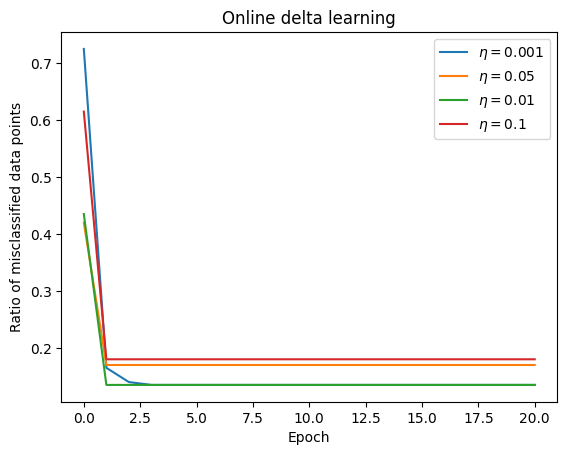

In [418]:
# Let us compare the online perceptron and delta learning on the non seperable dataset

errorsD1, W = train_sequential(0.001, norm_non_sep_data, T, "delta", 20, 0.1)
errorsD2, W = train_sequential(0.05, norm_non_sep_data, T, "delta", 20, 0.1)
errorsD3, W = train_sequential(0.01, norm_non_sep_data, T, "delta", 20, 0.1)
errorsD4, W = train_sequential(0.1, norm_non_sep_data, T, "delta", 20, 0.1)

x = [int(i) for i in range(21)]
plt.figure()
plt.plot(x, errorsD1, label = "$\eta=0.001$")
plt.plot(x, errorsD2, label = "$\eta=0.05$")
plt.plot(x, errorsD3, label = "$\eta=0.01$")
plt.plot(x, errorsD4, label = "$\eta=0.1$")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Ratio of misclassified data points")
plt.title("Online delta learning")
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/2775846793.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsP1, label = "$\eta=0.001$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/2775846793.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsP2, label = "$\eta=0.05$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/2775846793.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x, errorsP3, label = "$\eta=0.01$")
/var/folders/f4/696wvzy10_x0nx1mhv2tsws80000gn/T/ipykernel_97003/2775846793

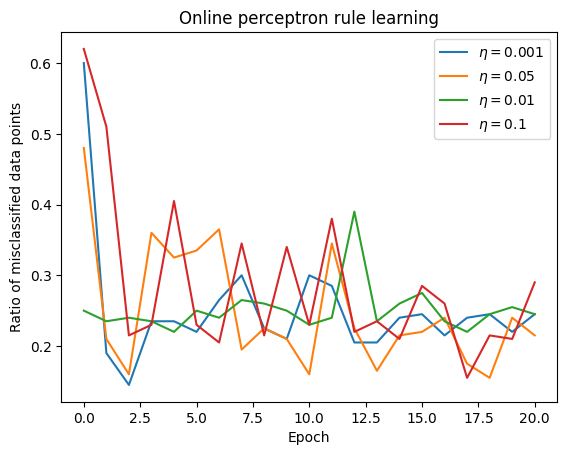

In [420]:
errorsP1, W = train_sequential(0.001, norm_non_sep_data, T, "perceptron", 20, 0.1)
errorsP2, W = train_sequential(0.05, norm_non_sep_data, T, "perceptron", 20, 0.1)
errorsP3, W = train_sequential(0.01, norm_non_sep_data, T, "perceptron", 20, 0.1)
errorsP4, W = train_sequential(0.1, norm_non_sep_data, T, "perceptron", 20, 0.1)

x = [int(i) for i in range(21)]
plt.figure()
plt.plot(x, errorsP1, label = "$\eta=0.001$")
plt.plot(x, errorsP2, label = "$\eta=0.05$")
plt.plot(x, errorsP3, label = "$\eta=0.01$")
plt.plot(x, errorsP4, label = "$\eta=0.1$")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Ratio of misclassified data points")
plt.title("Online perceptron rule learning")
plt.show()

### Do batch on non normal data

In [440]:
m = 100
sum = 0
for i in range(100):
    rng = np.random.default_rng(i)
    errors, W = train_batch(0.01, non_sep_data, T, "delta", 20, 0.1, False)
    #print(f"Ratio of mislabeled data points {errors[-1]}")
    sum += errors[-1]
print(f"Average ratio of mislabeled data points after 100 iterations: {sum / 100}")

Average ratio of mislabeled data points after 100 iterations: 0.20895000000000008


In [436]:
m = 100
sum = 0
for i in range(100):
    # Remove 25% from each class
    rng = np.random.default_rng(i)
    T[T == 0] = -1
    frac = 0.25
    pos_idx = np.flatnonzero(T == 1)
    neg_idx = np.flatnonzero(T == -1)
    k_pos = int(np.floor(frac * pos_idx.size))
    k_neg = int(np.floor(frac * neg_idx.size))
    rm_pos = rng.choice(pos_idx, size=k_pos, replace=False) if k_pos > 0 else np.array([], dtype=int)
    rm_neg = rng.choice(neg_idx, size=k_neg, replace=False) if k_neg > 0 else np.array([], dtype=int)
    rm_idx = np.concatenate([rm_pos, rm_neg])
    keep_mask = np.ones(T.shape[0], dtype=bool)
    keep_mask[rm_idx] = False
    non_sep_data_A = non_sep_data[:, keep_mask]     
    T_A = T[keep_mask].reshape(-1,)
    
    errors, W = train_batch(0.01, non_sep_data_A, T_A, "delta", 20, 0.1, False)
    #plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
    #print(f"Ratio of mislabeled data points {count_mislabeled(non_sep_data, T, W, "delta") / 200}")
    sum += count_mislabeled(non_sep_data, T, W, "delta") / 200

print(f"Average ratio of mislabeled data points after 100 iterations: {sum / 100}")


Average ratio of mislabeled data points after 100 iterations: 0.17525000000000016


In [446]:
m = 100
sum = 0
for i in range(100):   
    # Remove 50% from class A
    rng = np.random.default_rng(i)
    T[T == 0] = -1
    frac = 0.50
    pos_idx = np.flatnonzero(T == 1)
    neg_idx = np.flatnonzero(T == -1)
    k_pos = int(np.floor(frac * pos_idx.size))
    k_neg = int(np.floor(0 * neg_idx.size))
    rm_pos = rng.choice(pos_idx, size=k_pos, replace=False) if k_pos > 0 else np.array([], dtype=int)
    rm_neg = rng.choice(neg_idx, size=k_neg, replace=False) if k_neg > 0 else np.array([], dtype=int)
    rm_idx = np.concatenate([rm_pos, rm_neg])
    keep_mask = np.ones(T.shape[0], dtype=bool)
    keep_mask[rm_idx] = False
    non_sep_data_B = non_sep_data[:, keep_mask]     
    T_B = T[keep_mask].reshape(-1,)


    errors, W = train_batch(0.01, non_sep_data_B, T_B, "delta", 20, 0.1, False)
    #plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
    #print(f"Ratio of mislabeled data points {count_mislabeled(non_sep_data, T, W, "delta") / 200}")
    sum += count_mislabeled(non_sep_data, T, W, "delta") / 200

print(f"Average ratio of mislabeled data points after 100 iterations: {sum / 100}")

Average ratio of mislabeled data points after 100 iterations: 0.21640000000000018


In [447]:
m = 100
sum = 0
for i in range(m):
    # Remove 50% from class B
    rng = np.random.default_rng(i)
    T[T == 0] = -1
    frac = 0.50
    pos_idx = np.flatnonzero(T == 1)
    neg_idx = np.flatnonzero(T == -1)
    k_pos = int(np.floor(0 * pos_idx.size))
    k_neg = int(np.floor(frac * neg_idx.size))
    rm_pos = rng.choice(pos_idx, size=k_pos, replace=False) if k_pos > 0 else np.array([], dtype=int)
    rm_neg = rng.choice(neg_idx, size=k_neg, replace=False) if k_neg > 0 else np.array([], dtype=int)
    rm_idx = np.concatenate([rm_pos, rm_neg])
    keep_mask = np.ones(T.shape[0], dtype=bool)
    keep_mask[rm_idx] = False
    non_sep_data_C = non_sep_data[:, keep_mask]     
    T_C = T[keep_mask].reshape(-1,)


    errors, W = train_batch(0.01, non_sep_data_C, T_C, "delta", 20, 0.1, False)
    #plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
    #print(f"Ratio of mislabeled data points {count_mislabeled(non_sep_data, T, W, "delta") / 200}")
    sum += count_mislabeled(non_sep_data, T, W, "delta") / 200

print(f"Average ratio of mislabeled data points after 100 iterations: {sum / 100}")

Average ratio of mislabeled data points after 100 iterations: 0.22675000000000023


In [450]:
m = 100
sum = 0
for i in range(m):
    rng = np.random.default_rng(i)
    classA_label = 1
    idx_A = np.flatnonzero(T == classA_label)

    # x-coordinates for class A (row 0 == 'first row' in MATLAB)
    x_A = non_sep_data[0, idx_A]
    idx_A_neg = idx_A[x_A < 0]
    idx_A_pos = idx_A[x_A > 0]
    # (Points exactly at x==0 are kept.)

    # How many to remove
    k_neg = int(np.floor(0.20 * idx_A_neg.size))
    k_pos = int(np.floor(0.80 * idx_A_pos.size))

    # RNG (reuse existing rng if you already have one)
    try:
        rng
    except NameError:
        rng = np.random.default_rng()

    rm_neg = rng.choice(idx_A_neg, size=k_neg, replace=False) if k_neg > 0 else np.array([], dtype=int)
    rm_pos = rng.choice(idx_A_pos, size=k_pos, replace=False) if k_pos > 0 else np.array([], dtype=int)

    rm_idx = np.concatenate([rm_neg, rm_pos])

    keep_mask = np.ones(T.shape[0], dtype=bool)
    keep_mask[rm_idx] = False

    non_sep_data_D = non_sep_data[:, keep_mask]
    T_D = T[keep_mask] 


    errors, W = train_batch(0.01, non_sep_data_D, T_D, "delta", 20, 0.1, False)
    #plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
    #print(f"Ratio of mislabeled data points {count_mislabeled(non_sep_data, T, W, "delta") / 200}")
    sum += count_mislabeled(non_sep_data, T, W, "delta") / 200

print(f"Average ratio of mislabeled data points after 100 iterations: {sum / 100}")

Average ratio of mislabeled data points after 100 iterations: 0.2696500000000002


### Lets use these datasets in perceptron learning

TPR: 0.99999999999999 TNR: 0.34999999999999654


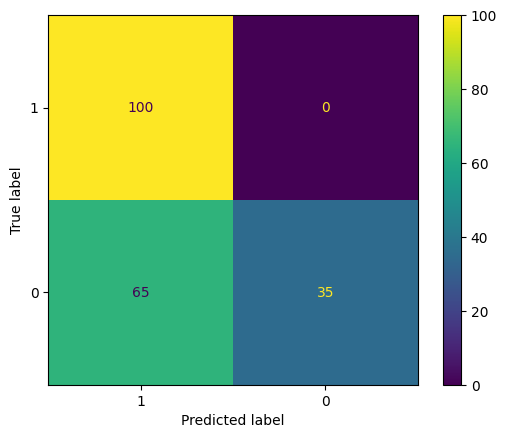

In [ ]:
T[T==-1] = 0
errors, W = train_sequential(0.01, non_sep_data_A, T_A, "perceptron", 20, 0.1, False)
#plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
y_pred = [1 if W @ non_sep_data[:,i] > 0 else 0 for i in range(non_sep_data.shape[1])]

cm = confusion_matrix(T, y_pred, labels=[1, 0])
# cm layout (rows: actual 1,-1; cols: predicted 1,-1):
# [[TP, FN],
#  [FP, TN]]

TP, FN = cm[0, 0], cm[0, 1]
FP, TN = cm[1, 0], cm[1, 1]
TPR = TP / (TP + FN + 1e-12)
TNR = TN / (TN + FP + 1e-12)

#print("TPR:", TPR, "TNR:", TNR)
#
## Plot
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
#disp.plot()

TPR: 0.5499999999999945 TNR: 0.7399999999999927


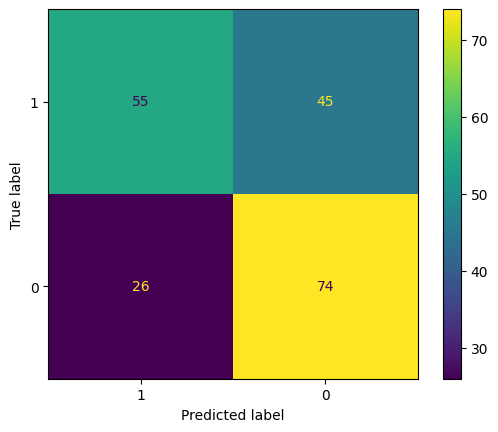

In [382]:
T[T==-1] = 0
errors, W = train_sequential(0.01, non_sep_data_B, T_B, "perceptron", 20, 0.1, False)
#plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
y_pred = [1 if W @ non_sep_data[:,i] > 0 else 0 for i in range(non_sep_data.shape[1])]

cm = confusion_matrix(T, y_pred, labels=[1, 0])
# cm layout (rows: actual 1,-1; cols: predicted 1,-1):
# [[TP, FN],
#  [FP, TN]]

TP, FN = cm[0, 0], cm[0, 1]
FP, TN = cm[1, 0], cm[1, 1]
TPR = TP / (TP + FN + 1e-12)
TNR = TN / (TN + FP + 1e-12)

print("TPR:", TPR, "TNR:", TNR)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

TPR: 0.99999999999999 TNR: 0.2099999999999979


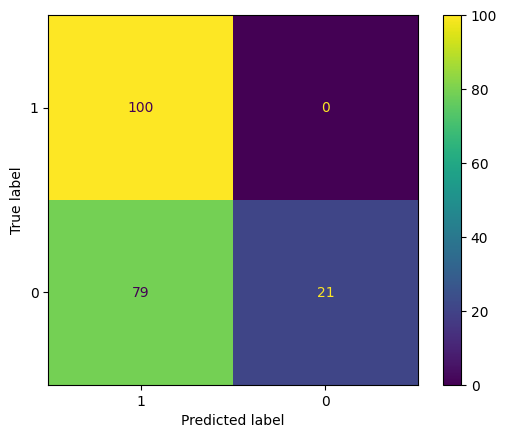

In [372]:
T[T==-1] = 0
errors, W = train_sequential(0.01, non_sep_data_C, T_C, "perceptron", 20, 0.1, False)
#plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
y_pred = [1 if W @ non_sep_data[:,i] > 0 else 0 for i in range(non_sep_data.shape[1])]

cm = confusion_matrix(T, y_pred, labels=[1, 0])
# cm layout (rows: actual 1,-1; cols: predicted 1,-1):
# [[TP, FN],
#  [FP, TN]]

TP, FN = cm[0, 0], cm[0, 1]
FP, TN = cm[1, 0], cm[1, 1]
TPR = TP / (TP + FN + 1e-12)
TNR = TN / (TN + FP + 1e-12)

print("TPR:", TPR, "TNR:", TNR)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

TPR: 0.9799999999999902 TNR: 0.5799999999999942


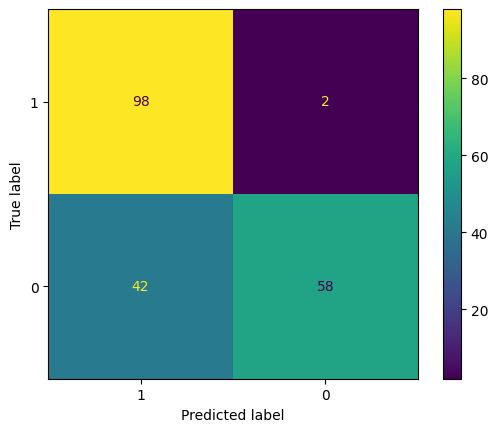

In [402]:
T[T==-1] = 0
errors, W = train_sequential(0.01, non_sep_data_D, T_D, "perceptron", 20, 0.1, False)
#plot_labeled_data(non_sep_data, T, "delta rule batch with learning rate 0.001", W)
y_pred = [1 if W @ non_sep_data[:,i] > 0 else 0 for i in range(non_sep_data.shape[1])]

cm = confusion_matrix(T, y_pred, labels=[1, 0])
# cm layout (rows: actual 1,-1; cols: predicted 1,-1):
# [[TP, FN],
#  [FP, TN]]

TP, FN = cm[0, 0], cm[0, 1]
FP, TN = cm[1, 0], cm[1, 1]
TPR = TP / (TP + FN + 1e-12)
TNR = TN / (TN + FP + 1e-12)

print("TPR:", TPR, "TNR:", TNR)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()